In [103]:
import xarray as xr
from fsspec.implementations.http import HTTPFileSystem

The dataset can be accessed directly with `xarray` using `kerchunks`' `HTTPFileSystem`: This creates a virtual filesystem that maps the zarr chunks and metadata to HTTP endpoints running on XREDS

In [115]:
# We can access our API using fsspec's HTTPFileSystem
fs = HTTPFileSystem()

# The http mapper gives us a dict-like interface to the API
http_map = fs.get_mapper("http://0.0.0.0:8090/datasets/dbofs")

ds = xr.open_zarr(http_map, consolidated=True)
ds

<xarray.Dataset>
Dimensions:        (ocean_time: 539, tracer: 2, s_rho: 10, s_w: 11,
                    boundary: 4, eta_rho: 732, xi_rho: 119, eta_psi: 731,
                    xi_psi: 118, eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2023-03-15T01:00:00 ... 2023-0...
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/78)
    Akk_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r           (ocean_time, s_rho) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    Cs_w           (ocean_time, s_w) float64 dask.array<chunksize=(1, 11), meta=np.ndarray>
    ...             ...
    theta_s        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u              (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 732, 118), meta=np.ndarray>
    v              (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 731, 119), meta=np.ndarray>
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 6, 732, 119), meta=np.ndarray>
    xl             (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230315.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

We can plot the entire temperature variable at a specific time and depth using `matplotlib`

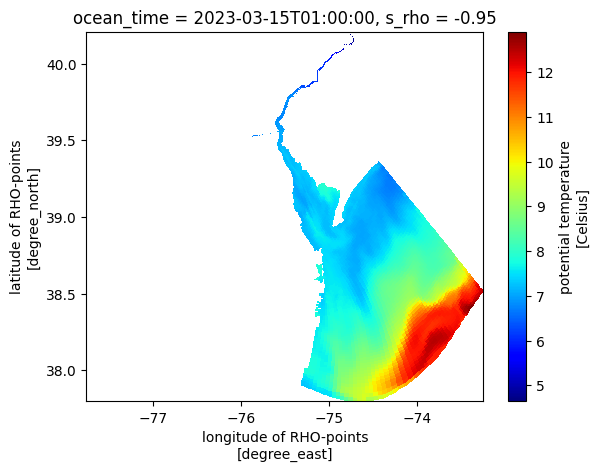

In [116]:
ds.temp.isel(ocean_time=0, s_rho=0).plot(x='lon_rho', y='lat_rho', cmap='jet')

/Users/matthewiannucci/Developer/aggregate_ofs/env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


(-77.73011589050293, -73.26415634155273)

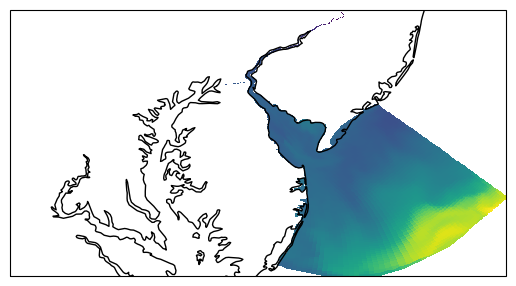

In [120]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

sst = ds.temp.isel(ocean_time=0, s_rho=0).values

# plt.pcolormesh(ds.lon_rho, ds.lat_rho, temp)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
plt.pcolormesh(ds.lon_rho.values, ds.lat_rho.values, sst, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_ylim(ds.lat_rho.min(), ds.lat_rho.max())
ax.set_xlim(ds.lon_rho.min(), ds.lon_rho.max())

In [125]:
import cartopy.geodesic
import numpy as np

def argsel2d(lons, lats, lon0, lat0):
    """Find the indices of coordinate pair closest to another point.
    Inputs
    ------
    lons: DataArray, ndarray, list
        Longitudes of points to search through for closest point.
    lats: DataArray, ndarray, list
        Latitudes of points to search through for closest point.
    lon0: float, int
        Longitude of comparison point.
    lat0: float, int
        Latitude of comparison point.
    Returns
    -------
    Index or indices of location in coordinate pairs made up of lons, lats
    that is closest to location lon0, lat0. Number of dimensions of
    returned indices will correspond to the shape of input lons.
    Notes
    -----
    This function uses Great Circle distance to calculate distances assuming
    longitudes and latitudes as point coordinates. Uses cartopy function
    `Geodesic`: https://scitools.org.uk/cartopy/docs/latest/cartopy/geodesic.html
    If searching for the closest grid node to a lon/lat location, be sure to
    use the correct horizontal grid (rho, u, v, or psi). This is accounted for
    if this function is used through the accessor.
    Example usage
    -------------
    >>> xroms.argsel2d(ds.lon_rho, ds.lat_rho, -96, 27)
    """

    # input lons and lats can be multidimensional and might be DataArrays or lists
    pts = list(zip(*(np.asarray(lons).flatten(), np.asarray(lats).flatten())))
    endpts = list(zip(*(np.asarray(lon0).flatten(), np.asarray(lat0).flatten())))

    G = cartopy.geodesic.Geodesic()  # set up class
    dist = np.asarray(G.inverse(pts, endpts)[:, 0])  # select distances specifically
    iclosest = abs(np.asarray(dist)).argmin()  # find indices of closest point
    # return index or indices in input array shape
    inds = np.unravel_index(iclosest, np.asarray(lons).shape)

    return inds

def sel2d(var, lons, lats, lon0, lat0):
    """Find the value of the var at closest location to lon0,lat0.
    Inputs
    ------
    var: DataArray, ndarray
        Variable to operate on.
    lons: DataArray, ndarray, list
        Longitudes of points to search through for closest point.
    lats: DataArray, ndarray, list
        Latitudes of points to search through for closest point.
    lon0: float, int
        Longitude of comparison point.
    lat0: float, int
        Latitude of comparison point.
    Returns
    -------
    Value in var of location in coordinate pairs made up of lons, lats
    that is closest to location lon0, lat0. If var has other
    dimensions, they are brought along.
    Notes
    -----
    This function uses Great Circle distance to calculate distances assuming
    longitudes and latitudes as point coordinates. Uses cartopy function
    `Geodesic`: https://scitools.org.uk/cartopy/docs/latest/cartopy/geodesic.html
    If searching for the closest grid node to a lon/lat location, be sure to
    use the correct horizontal grid (rho, u, v, or psi). This is accounted for
    if this function is used through the accessor.
    This is meant to be used by the accessor to conveniently wrap
    `argsel2d`.
    Example usage
    -------------
    >>> xroms.sel2d(ds.temp, ds.lon_rho, ds.lat_rho, -96, 27)
    """

    assert isinstance(var, xr.DataArray), "Input a DataArray"
    inds = argsel2d(lons, lats, lon0, lat0)

    return var.isel({lats.dims[0]: inds[0], lats.dims[1]: inds[1]})

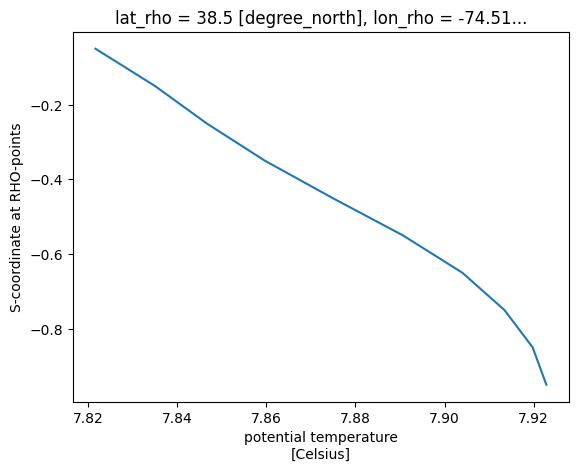

In [128]:
temp = sel2d(ds.temp, ds.lon_rho, ds.lat_rho, -74.5, 38.5).isel(ocean_time=0)
temp.plot(y='s_rho')